# Plot the time of saccade vs. the length of a saccade

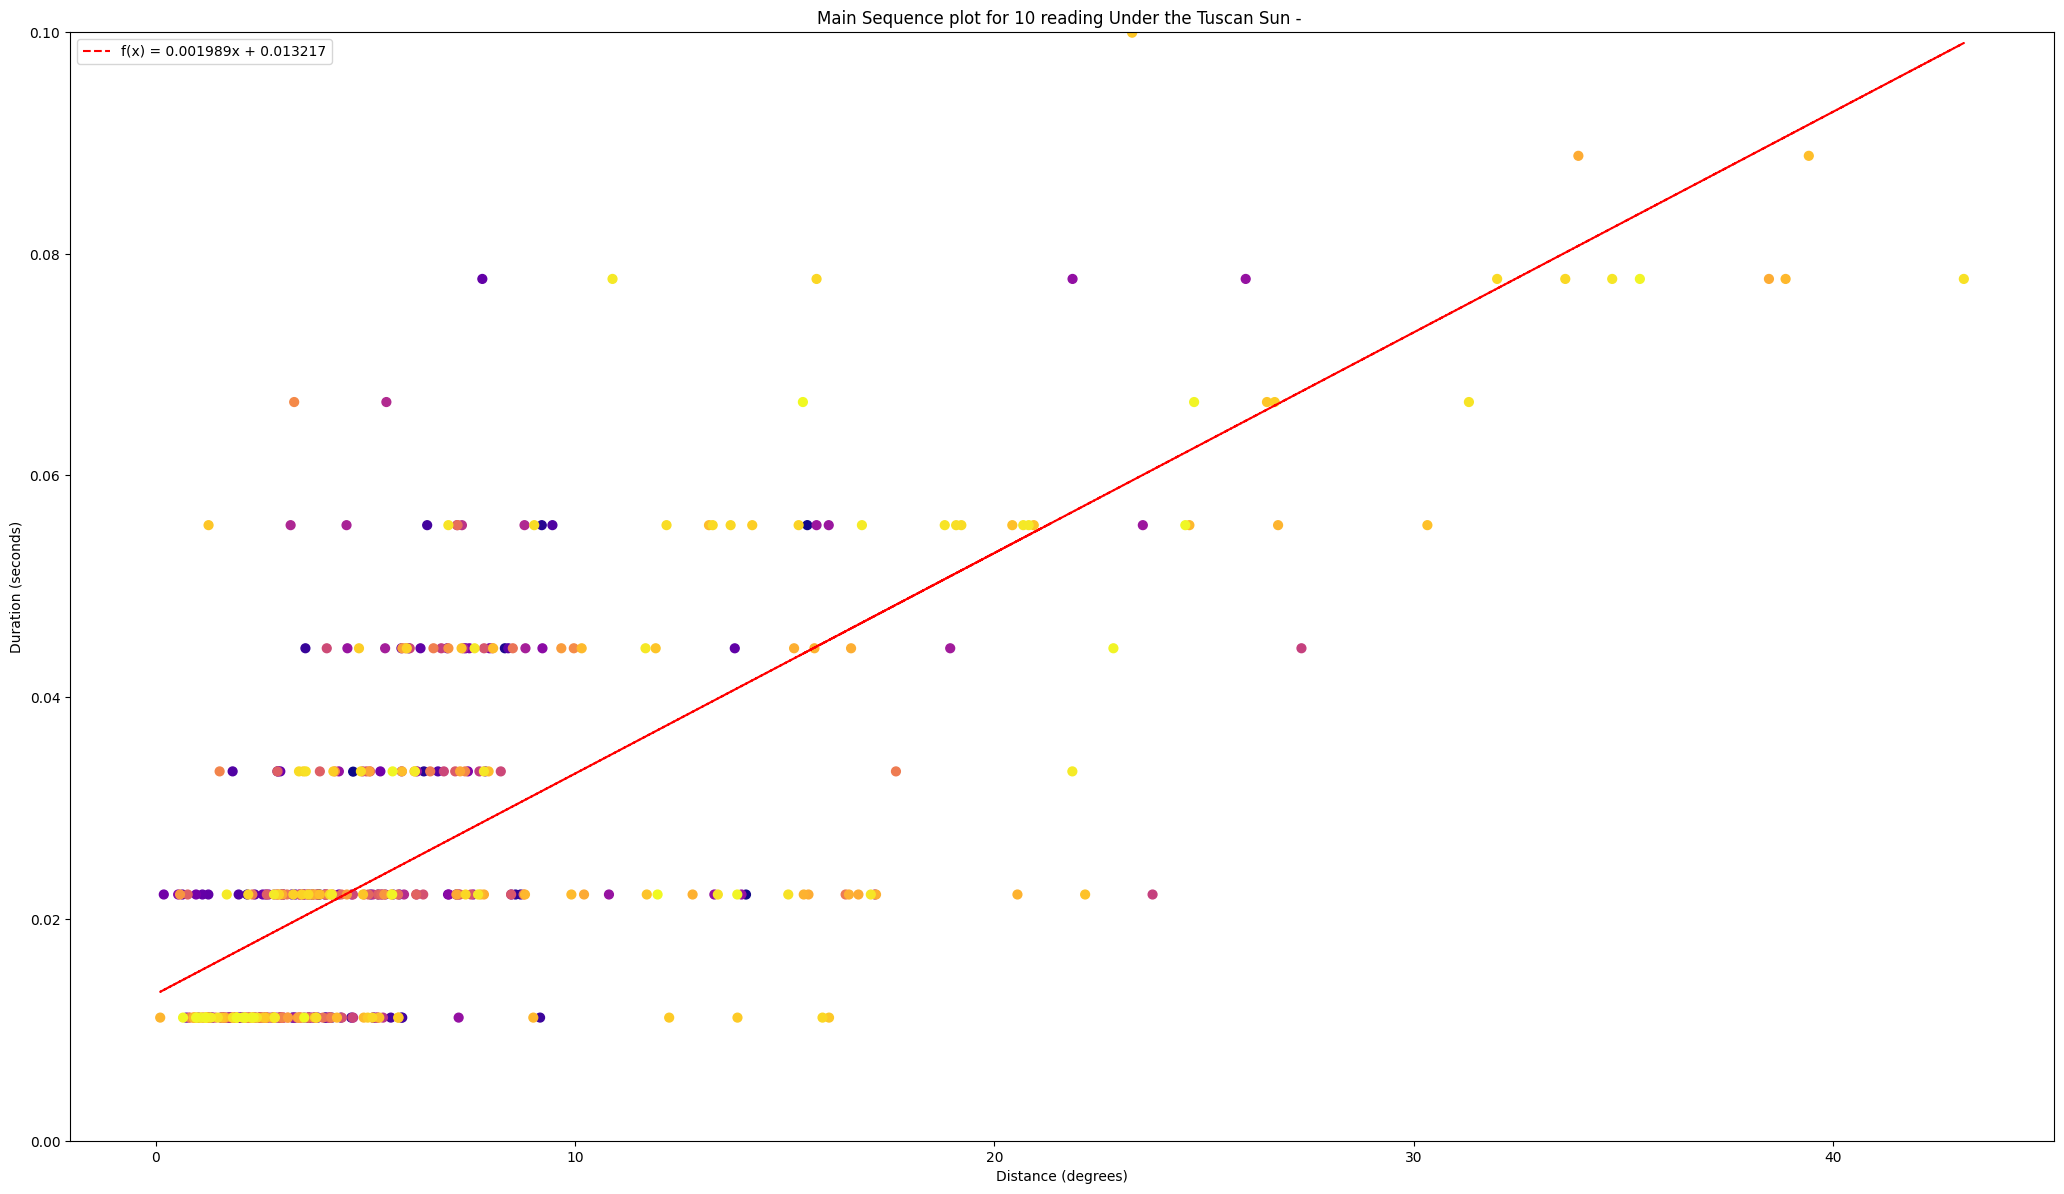

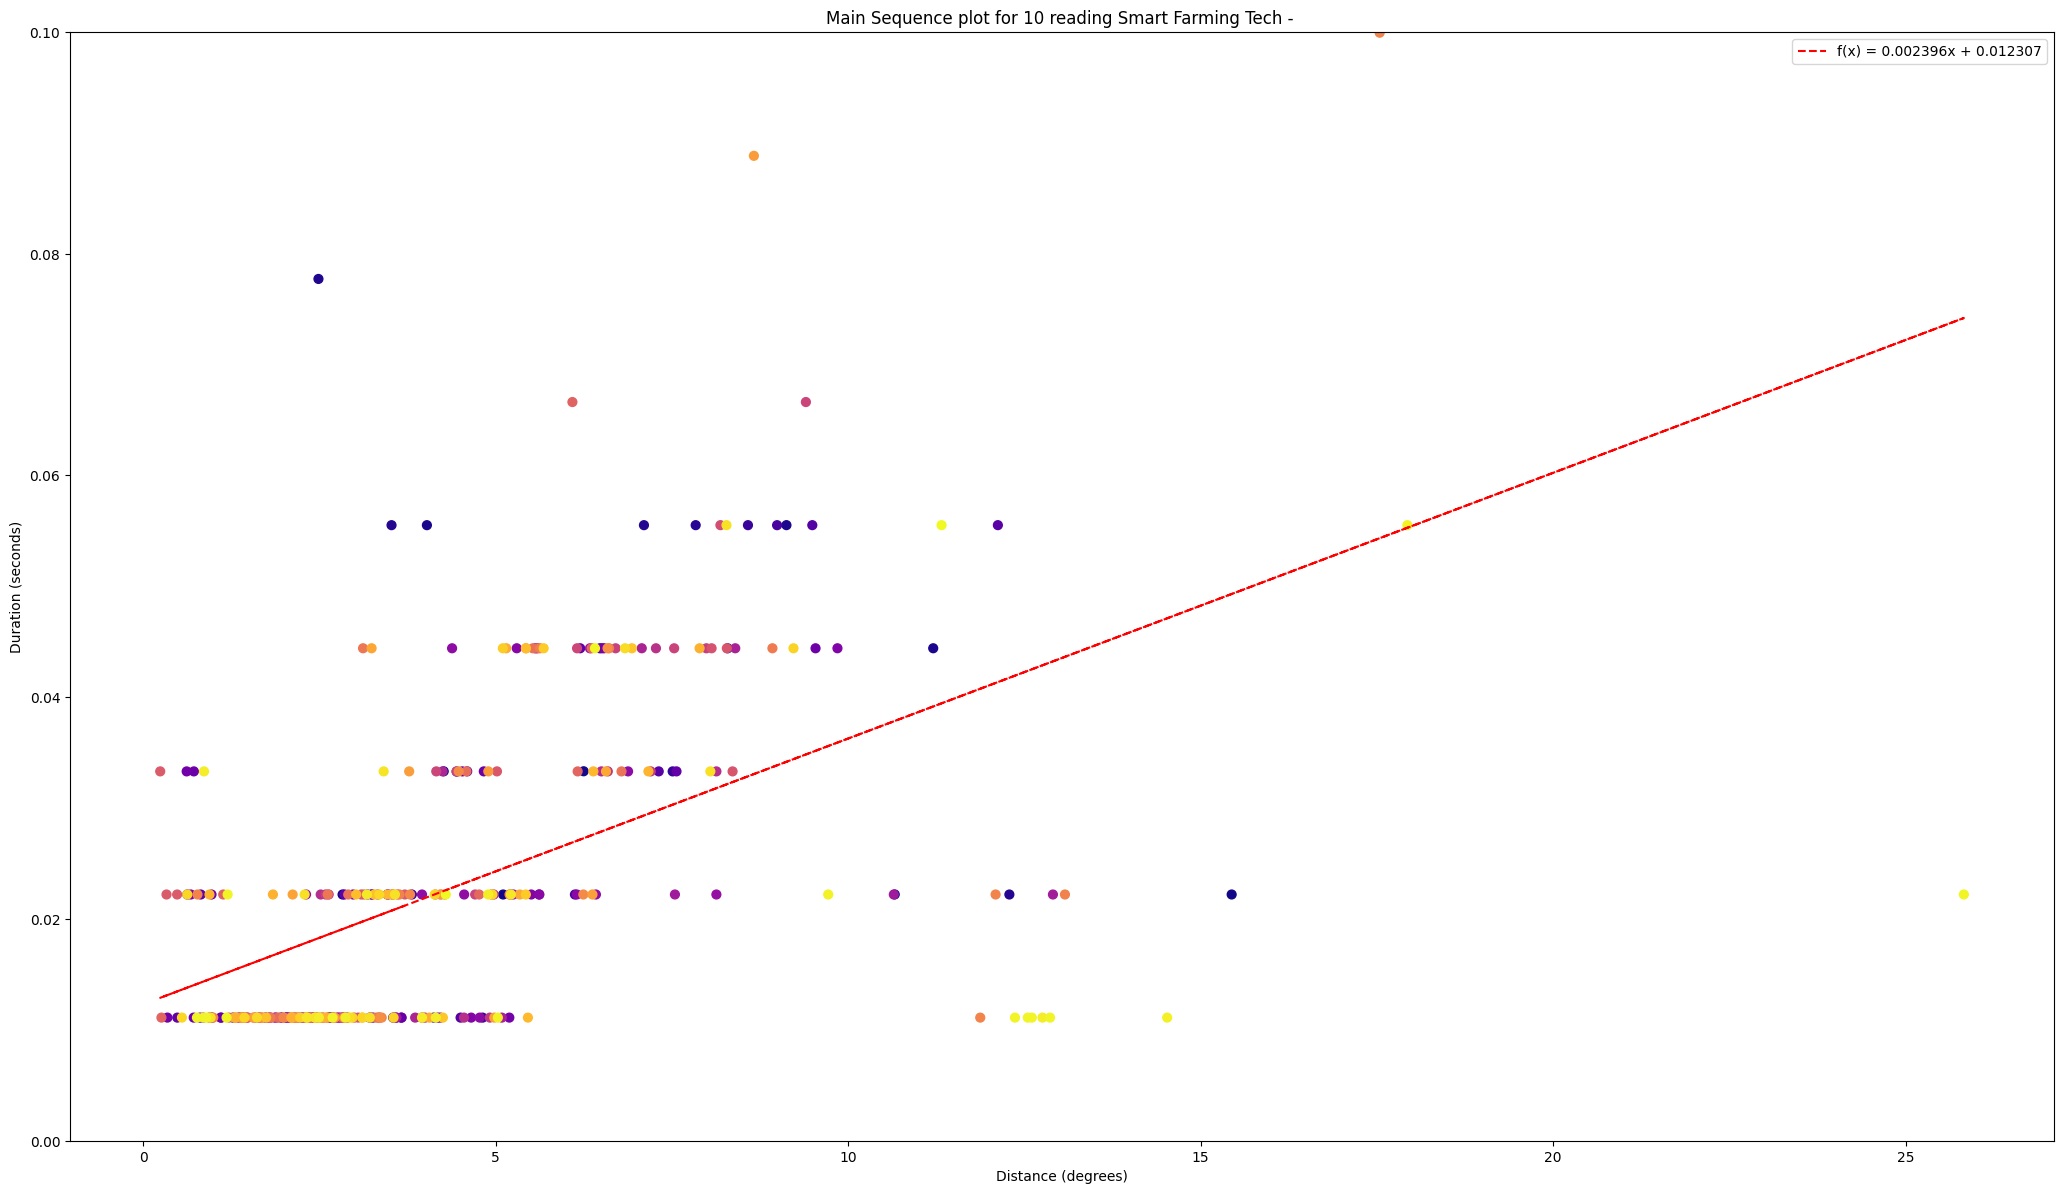

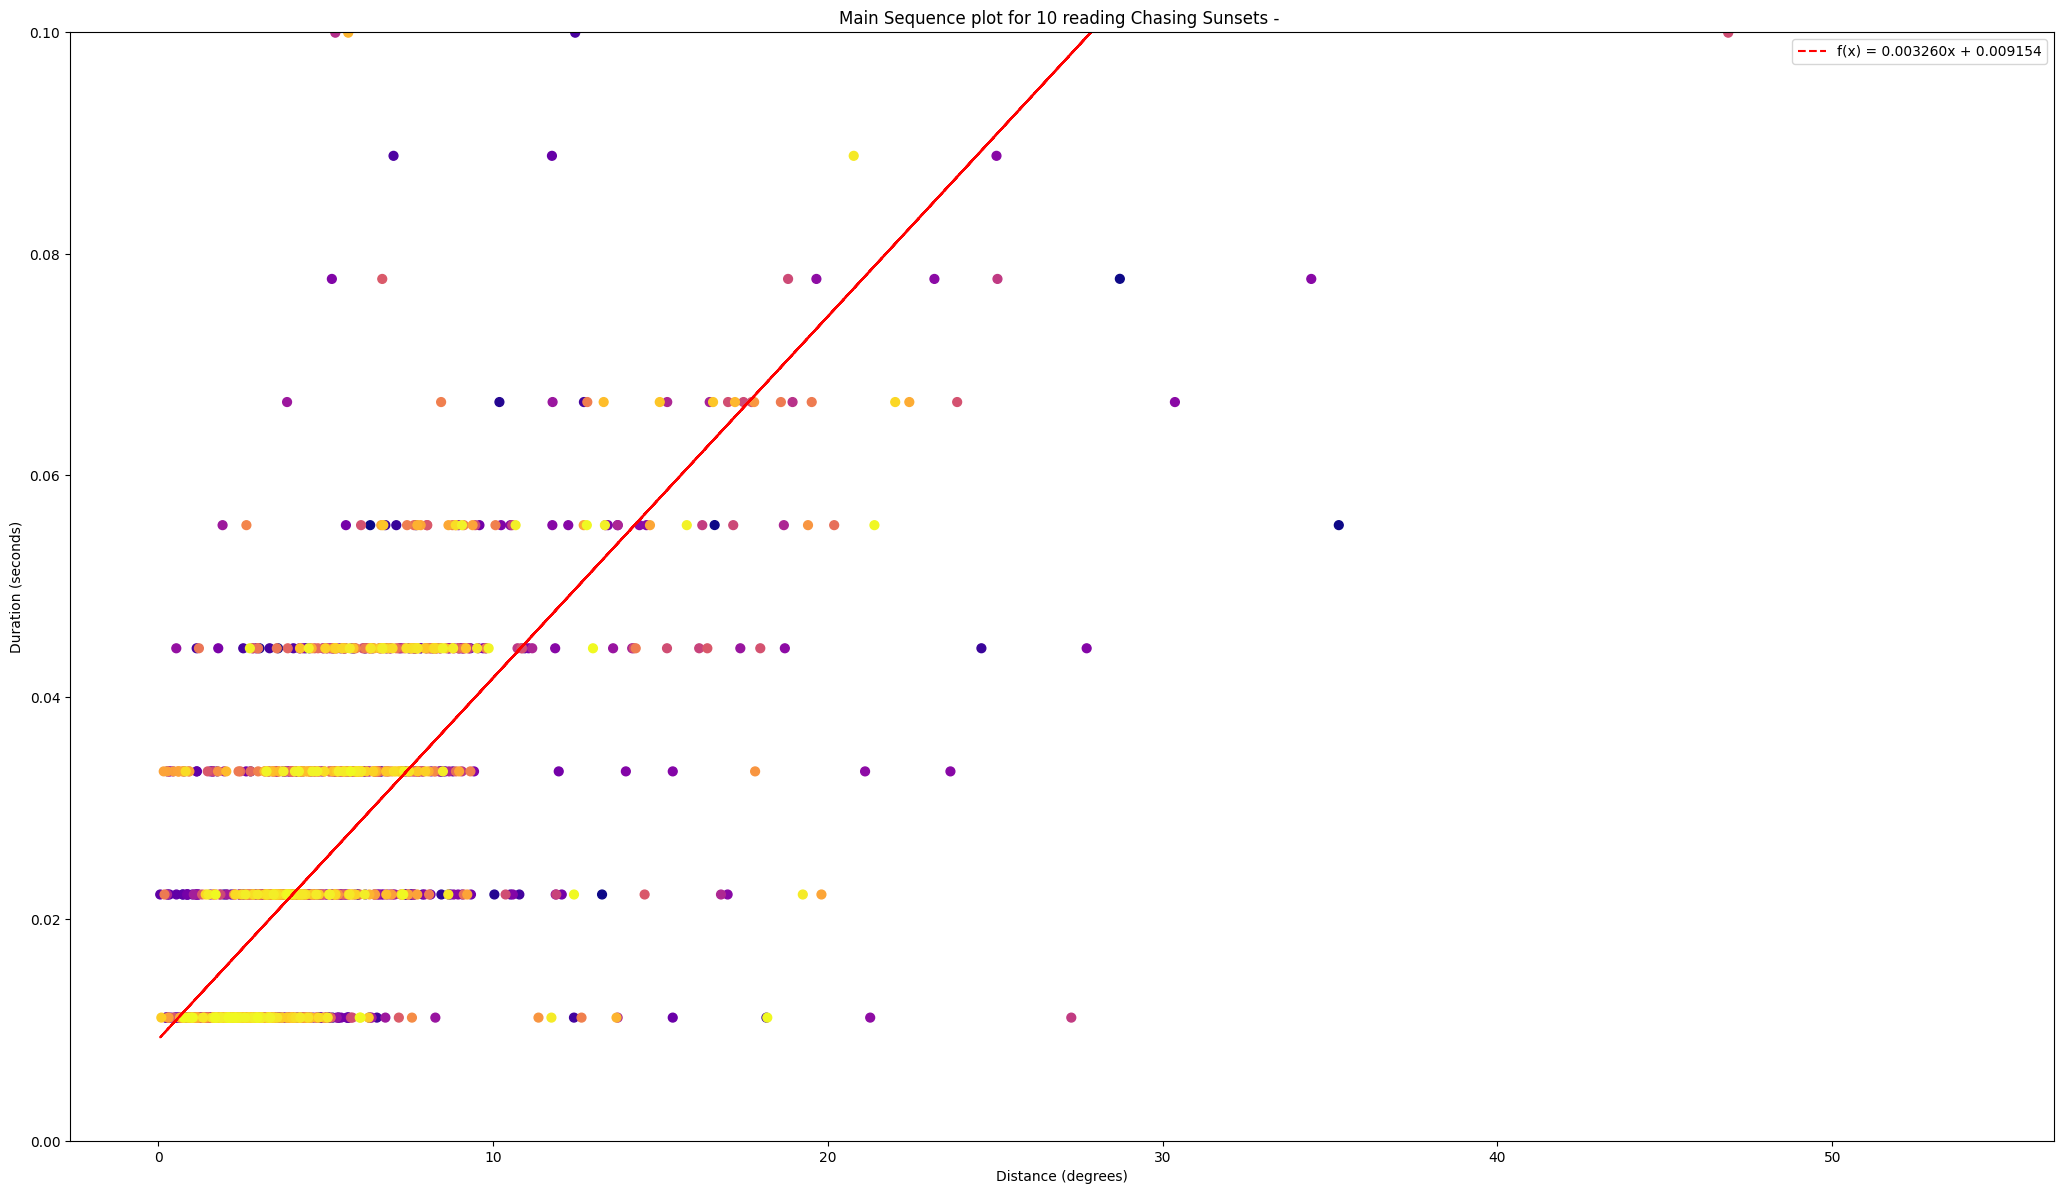

In [15]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from utils import (
    DEGREES_PER_PIXEL,
    TIMESTAMP_IDENT,
    X_PIXELS,
    Y_PIXELS,
    Events,
    extract_gaze_data_between_timestamps_proper,
    get_participant_dominant_eye,
)
import json

from velocityThreshold import detect_fix_ivt, find_sacc_from_fix

EYE_TRACKER_FOLDER = "eye_tracker_data/"
GAZE_DATA = []
GAZE_DATA_BOOK = []
GAZE_DATA_PAGE = []

# participants that were told that they can change the settings beforehand
# participant_ids = [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
participant_ids = [10]
subquery = Events.select().where(Events.participant_id.in_(participant_ids))

for participant in participant_ids:
    books = subquery.where(
        (Events.event == "OPEN_BOOK")
        & (Events.participant_id == participant)
        # & (Events.new_value != "Chasing Sunsets - ")
    )
    for book in books:
        START_TIME_BOOK = book.time
        book_end = (
            subquery.where(Events.event == "CLOSE_BOOK")
            .where(Events.time > START_TIME_BOOK)
            .get()
        )
        END_TIME_BOOK = book_end.time

        # Get the events that have a timestamp less than the first CLOSE_BOOK event
        events_book = subquery.where(Events.time <= END_TIME_BOOK)

        LOW_RES = json.load(open("participants.json", "r"))[f"{book.participant_id}"][
            "low_resolution"
        ]

        # if not LOW_RES:
            # START_TIME_BOOK /= 1000
        # else:
            # continue
        formatted_time = datetime.fromtimestamp(START_TIME_BOOK).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )
        GAZE_FILE = f"{EYE_TRACKER_FOLDER}[{participant}]-{formatted_time}.json"
        f = open(GAZE_FILE, "r")
        GAZE_DATA_BOOK = json.load(f)
        f.close()

        DOMINANT_EYE = get_participant_dominant_eye(participant)

        timestamps = []
        x = []
        y = []

        # for each packet, plot the gaze point
        for packet in GAZE_DATA_BOOK["data"]:
            if packet[f"{DOMINANT_EYE}_gaze_point_validity"] == 0:
                continue
            x.append(
                (packet[f"{DOMINANT_EYE}_gaze_point_on_display_area"][0] * X_PIXELS)
                # * DEGREES_PER_PIXEL
            )
            y.append(
                (packet[f"{DOMINANT_EYE}_gaze_point_on_display_area"][1] * Y_PIXELS)
                # * DEGREES_PER_PIXEL
            )
            timestamps.append(packet[TIMESTAMP_IDENT])

        df = pd.DataFrame({"x": x, "y": y, "ts": timestamps})
        df = df.sort_values(by="ts")
        df = df.reset_index(drop=True)

        df["x"] = df["x"] * DEGREES_PER_PIXEL
        df["y"] = df["y"] * DEGREES_PER_PIXEL
        df["ts"] = df["ts"] / 1_000_000

        # display(df)
        SACCADIC_THRESHOLD = 80
        # Plot fixations
        fixations, v, labels = detect_fix_ivt(df, sacvel=SACCADIC_THRESHOLD)
        saccades = find_sacc_from_fix(fixations)
        # print(saccades)

        fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))
        # Make x axis go from 0 to 50
        # ax.set_xlim(0, 50)
        ax.set_ylim(0, 0.1)

        ax.set_title(f"Main Sequence plot for {participant} reading {book.new_value}")
        p = ax.scatter(
            saccades["dxy"],
            saccades["len"],
            c=saccades["ts"],
            s=40,
            cmap="plasma",
            # label=f"Participant {participant} - {book.new_value}",
        )

        # Make trendline
        z = np.polyfit(saccades["dxy"], saccades["len"], 1)
        p = np.poly1d(z)
        # Label with equation
        plt.plot(
            saccades["dxy"],
            p(saccades["dxy"]),
            "r--",
            label="f(x) = %.6fx + %.6f" % (z[0], z[1]),
        )

        interesting_ts = [
            156729816944,
            156687857665,
            156668959899,
            156729261778,
            156580200388,
            156525272547,
            156690178245,
            156729261779,
            156727007818,
            156668848865,
            156491540766,
        ]
        # Label each point with the timestamp
        for i, txt in enumerate(saccades["ts"]):
            if (txt * 1_000_000) in interesting_ts:
                ax.annotate(
                    txt,
                    (saccades["dxy"][i], saccades["len"][i]),
                    xytext=(saccades["dxy"][i], saccades["len"][i]),
                )

        ax.set_xlabel("Distance (degrees)")
        ax.set_ylabel("Duration (seconds)")
        ax.legend()

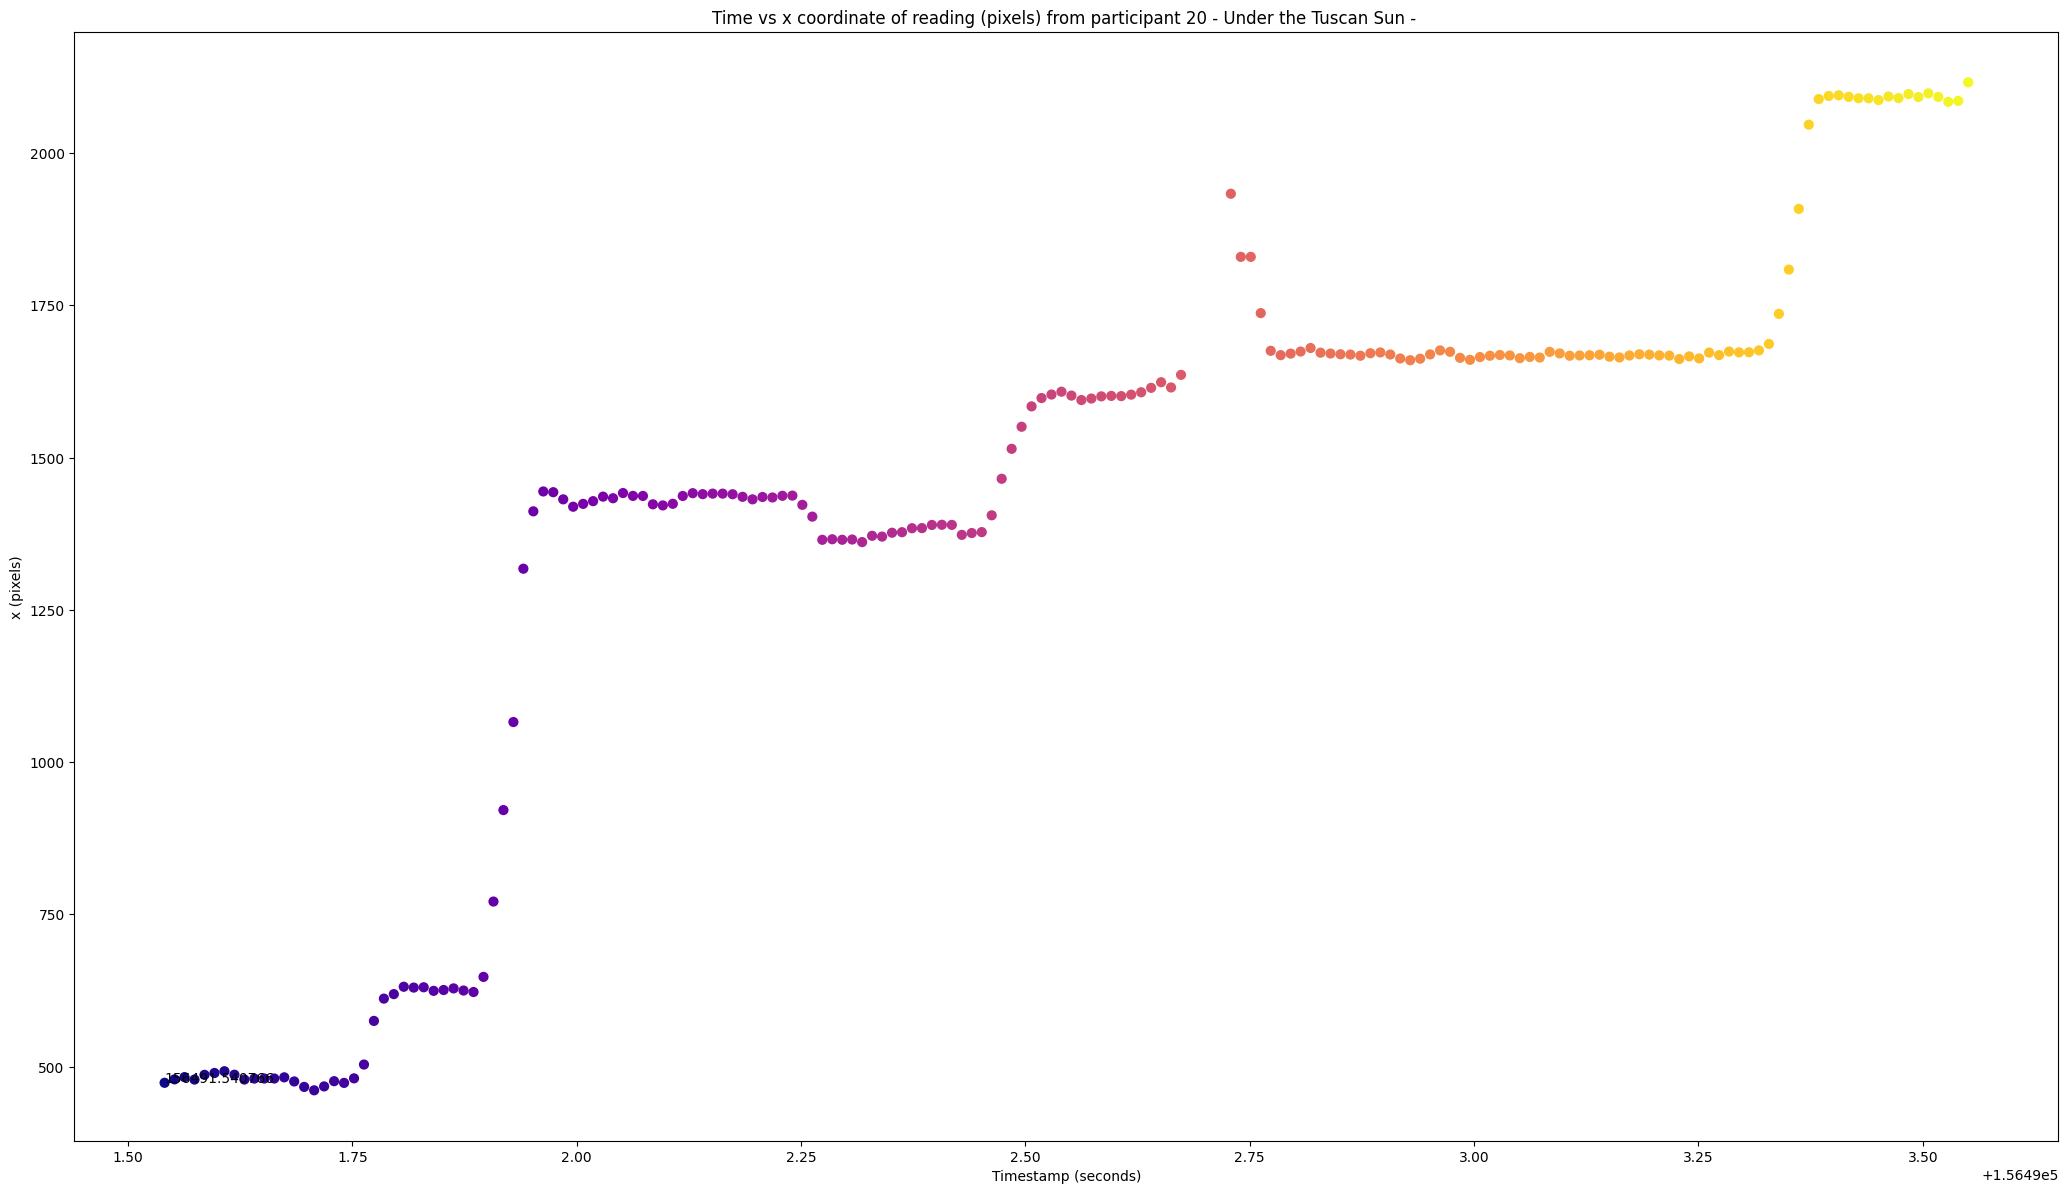

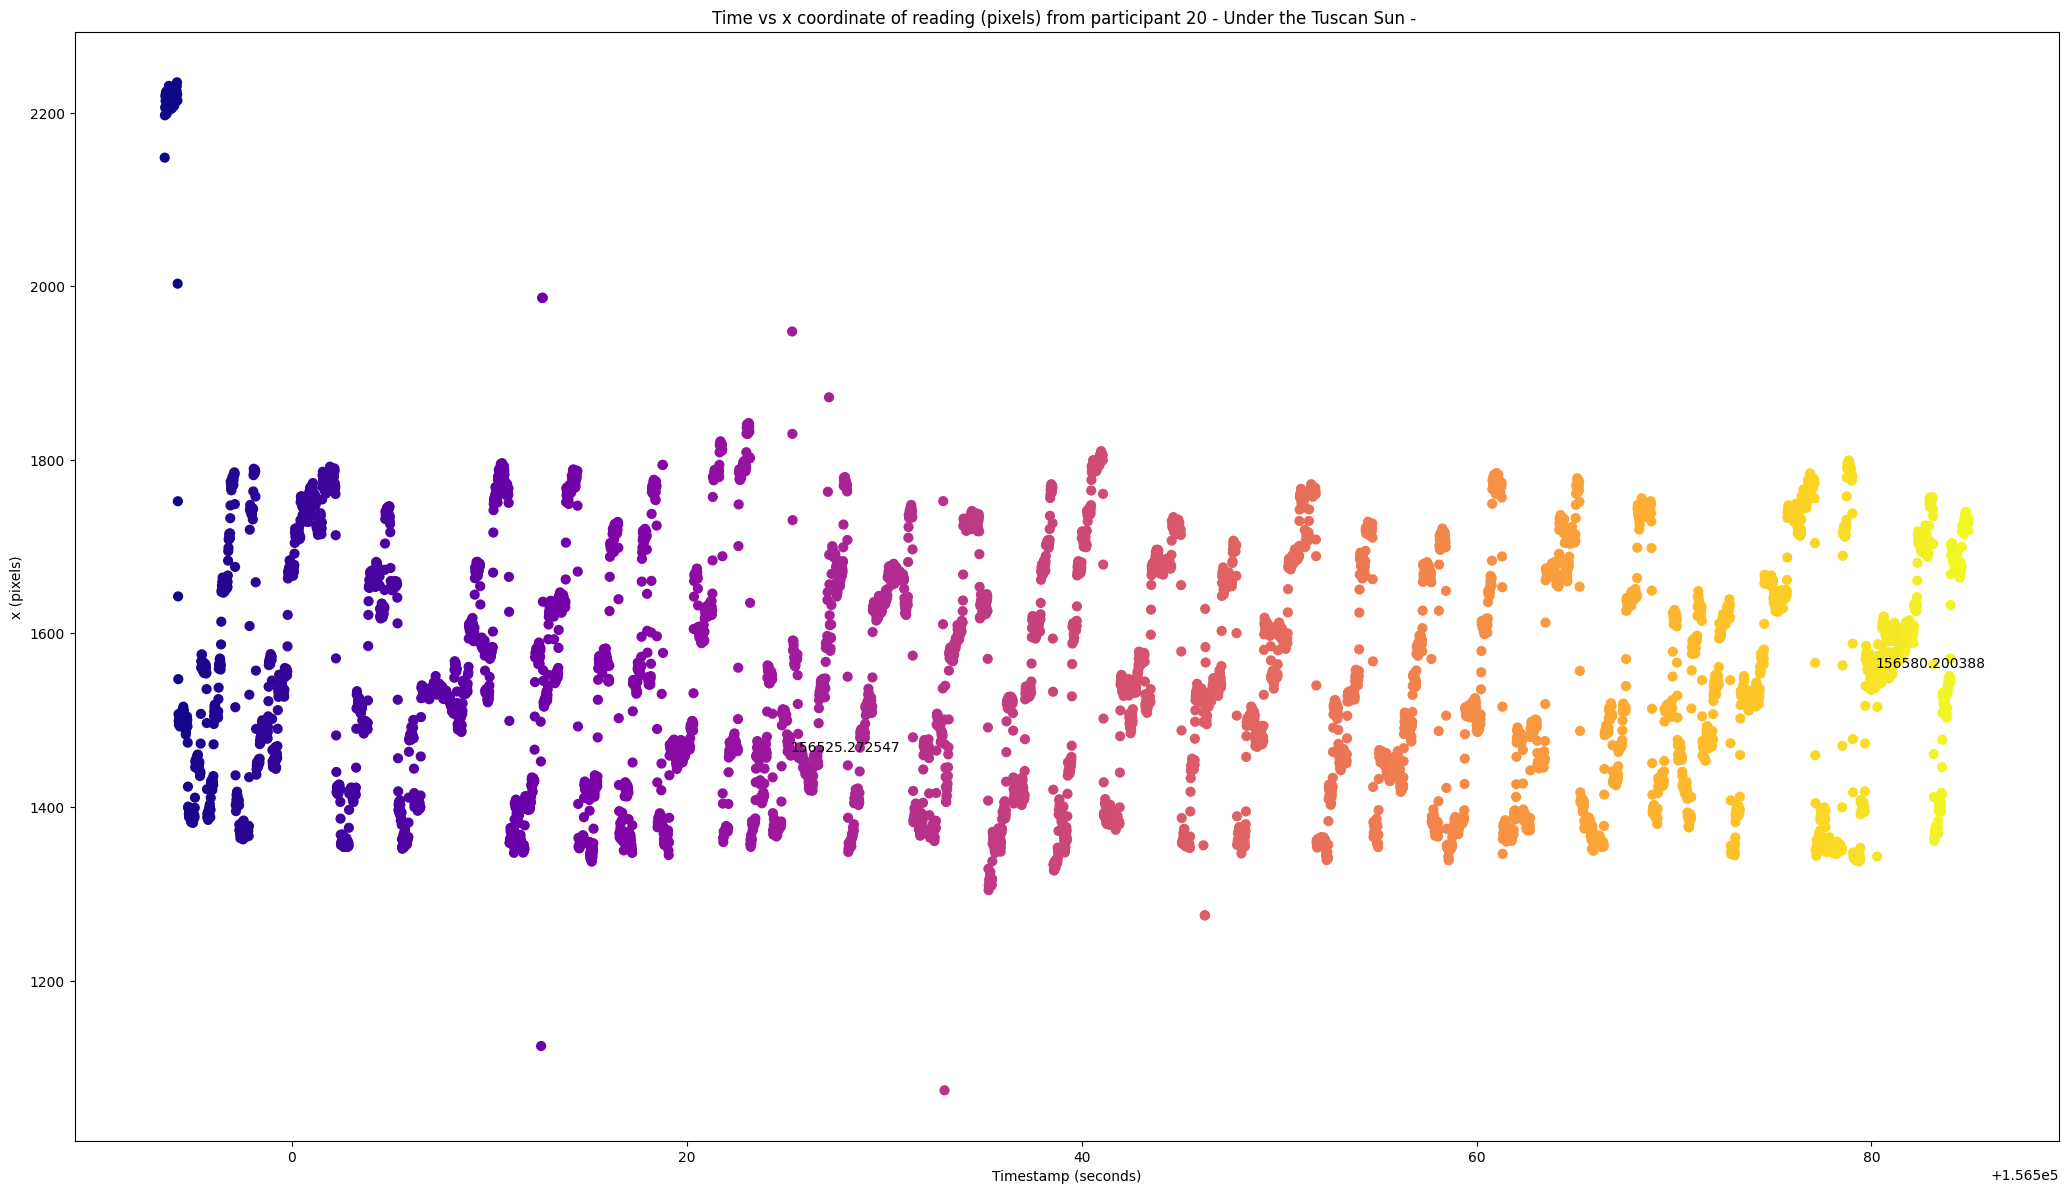

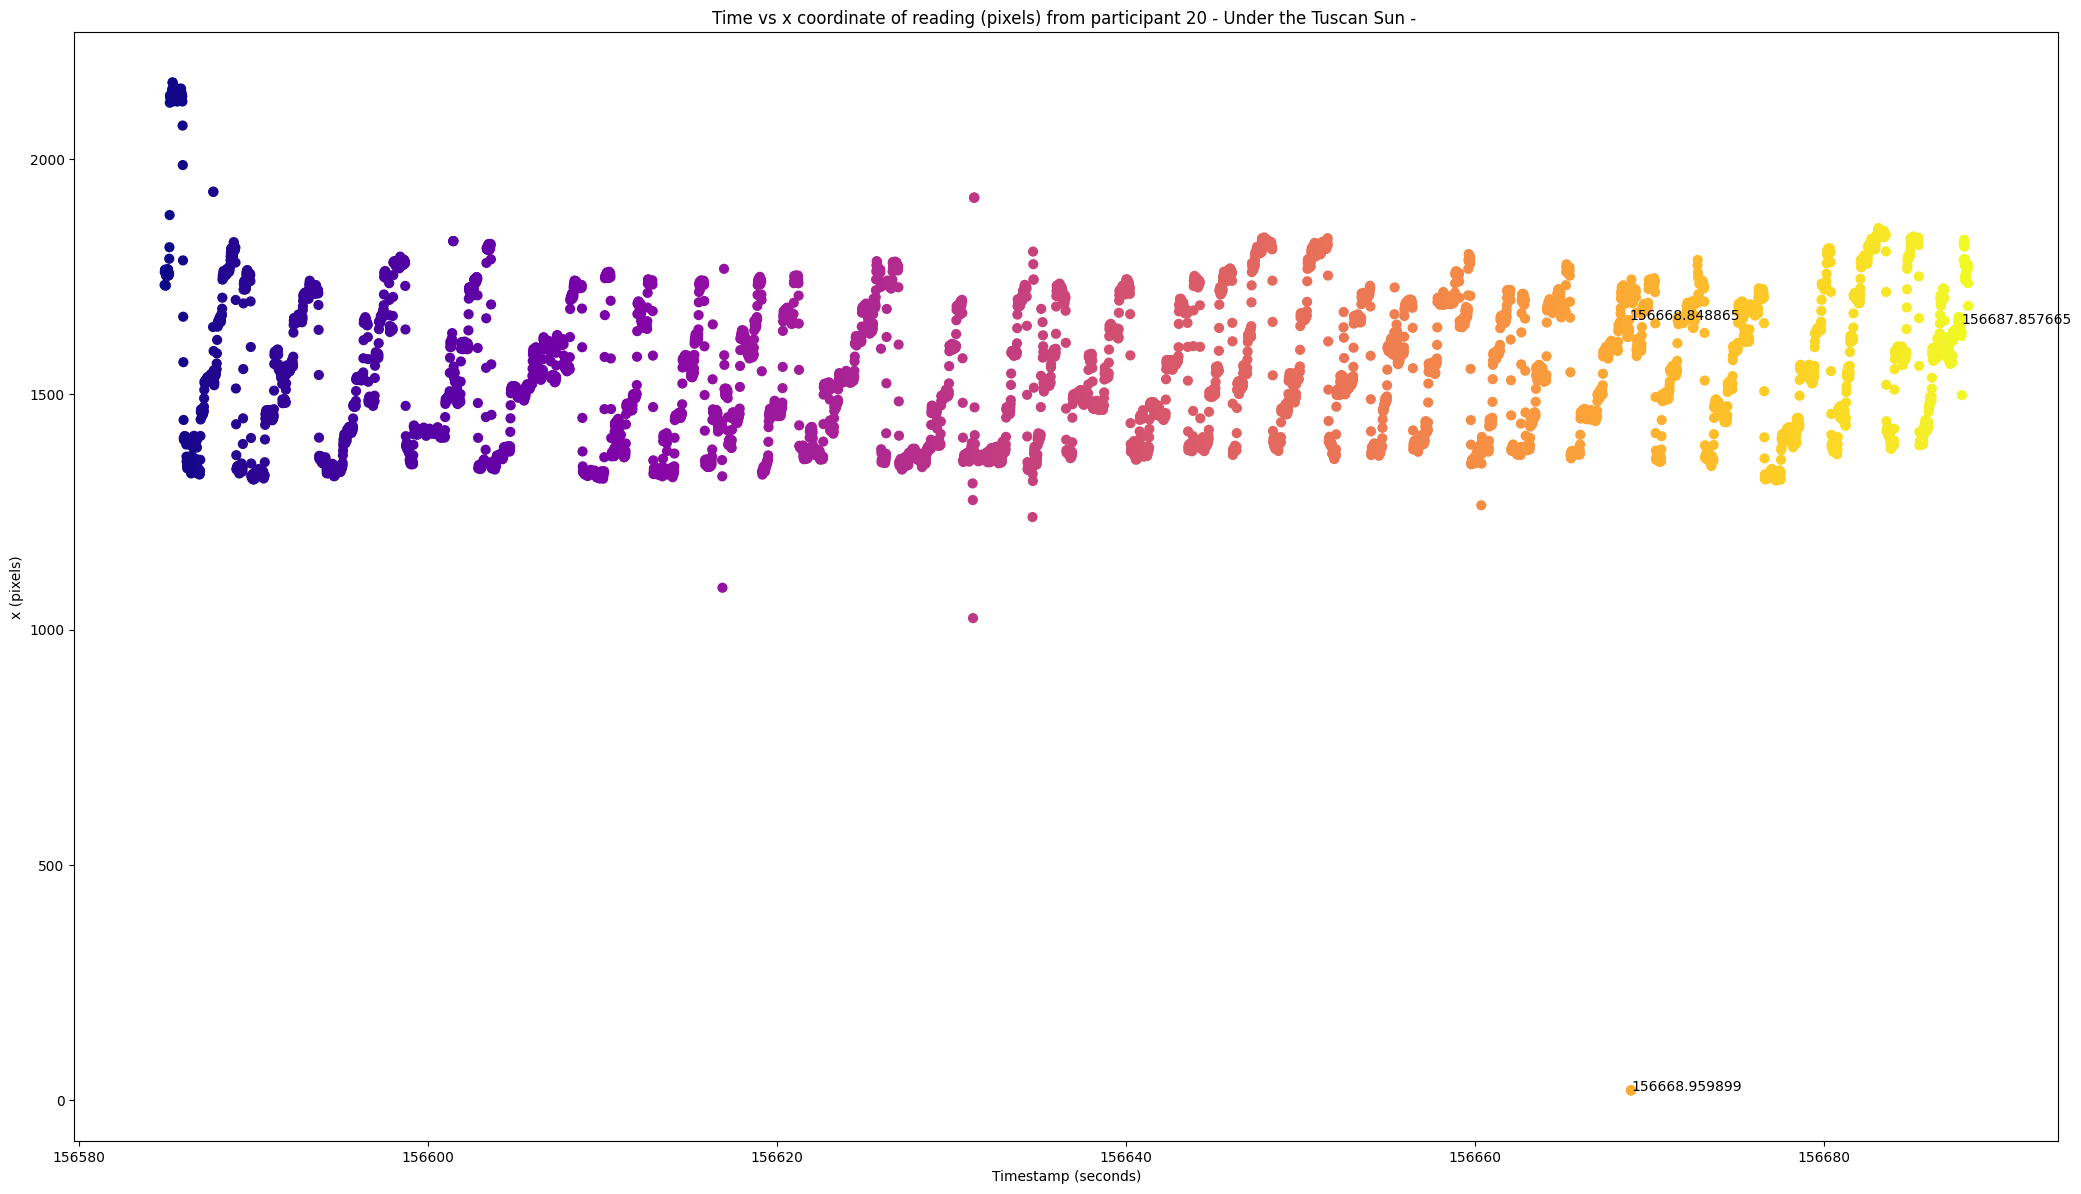

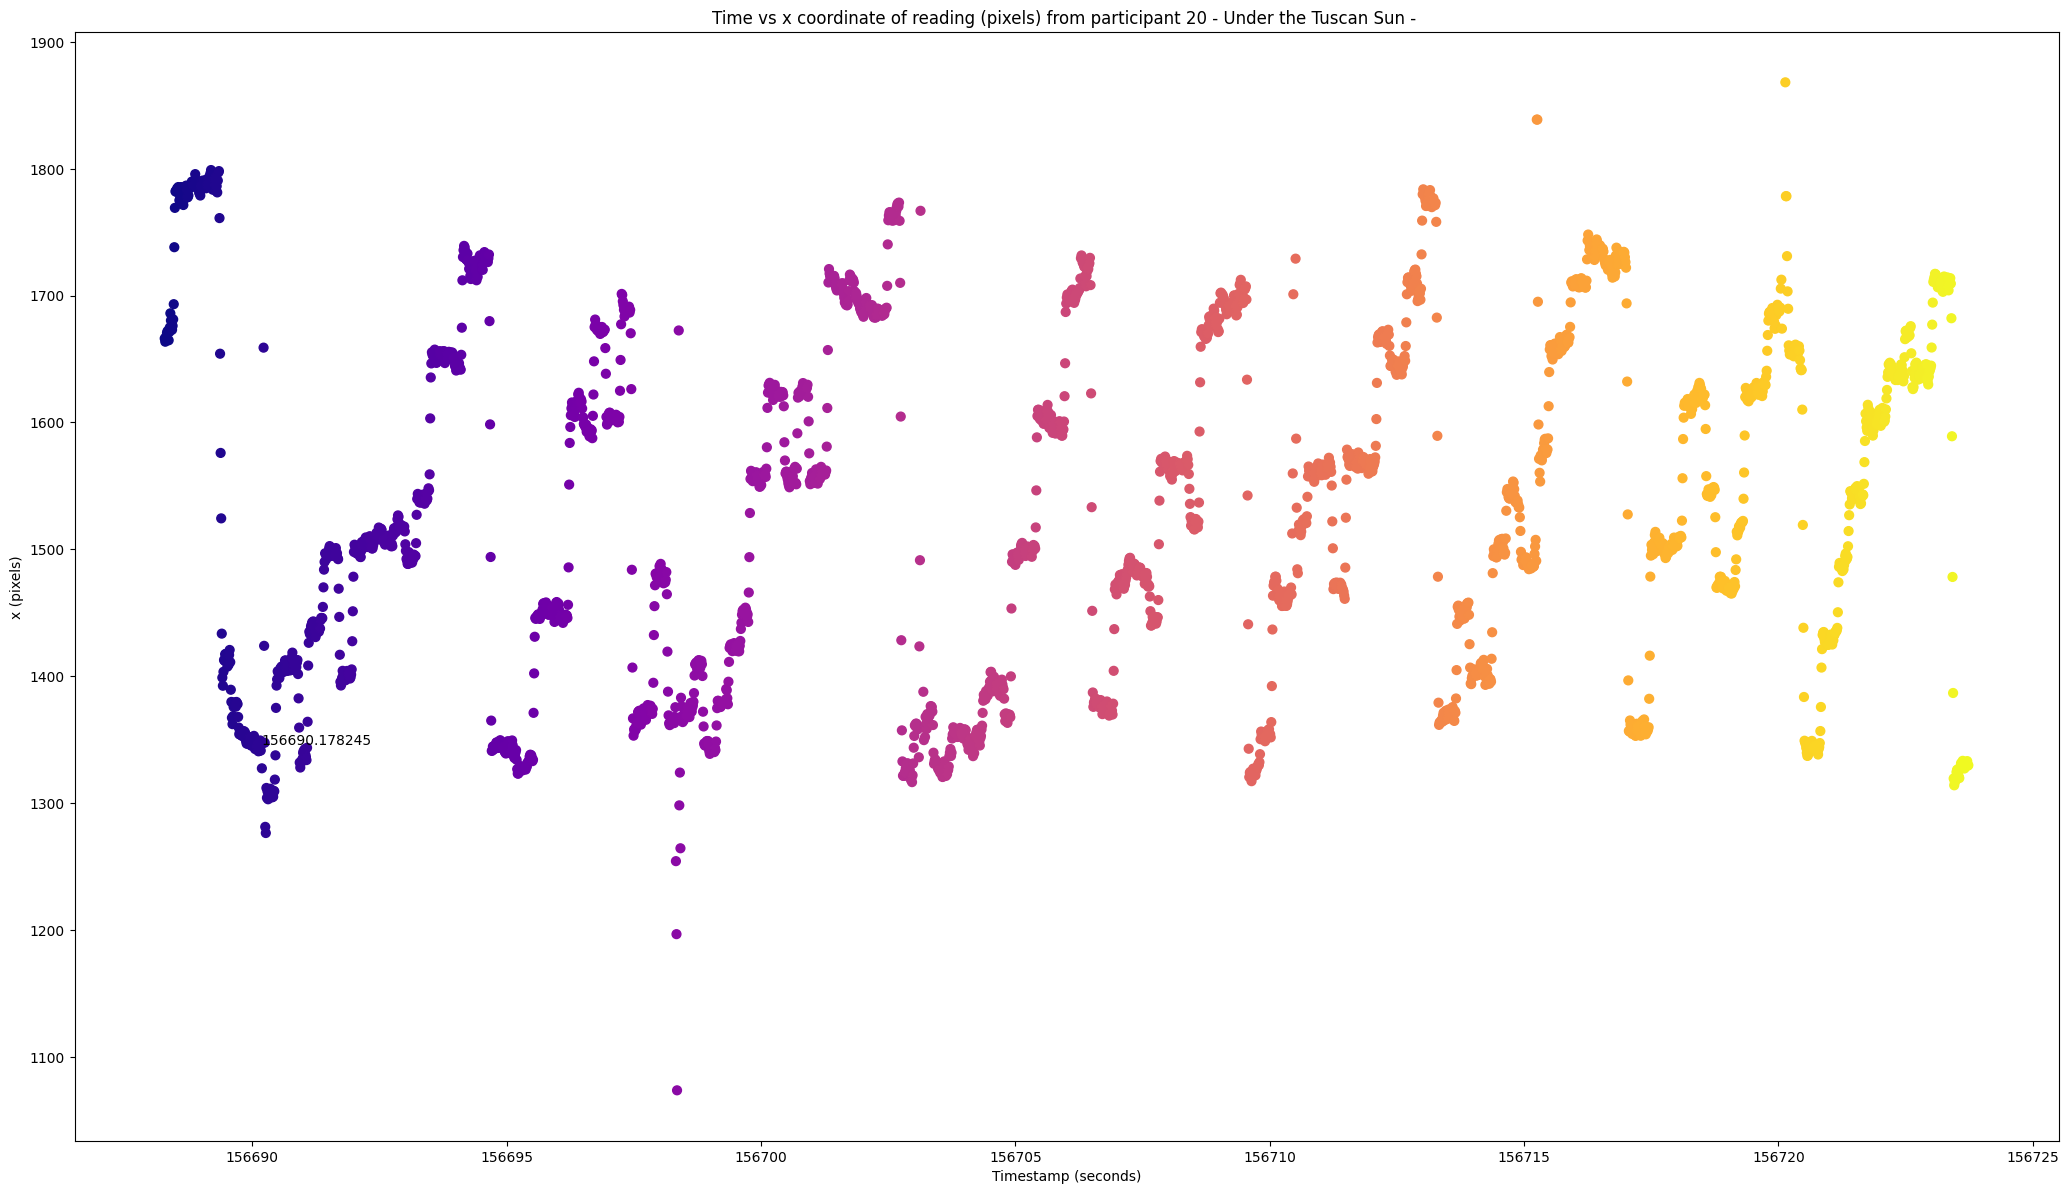

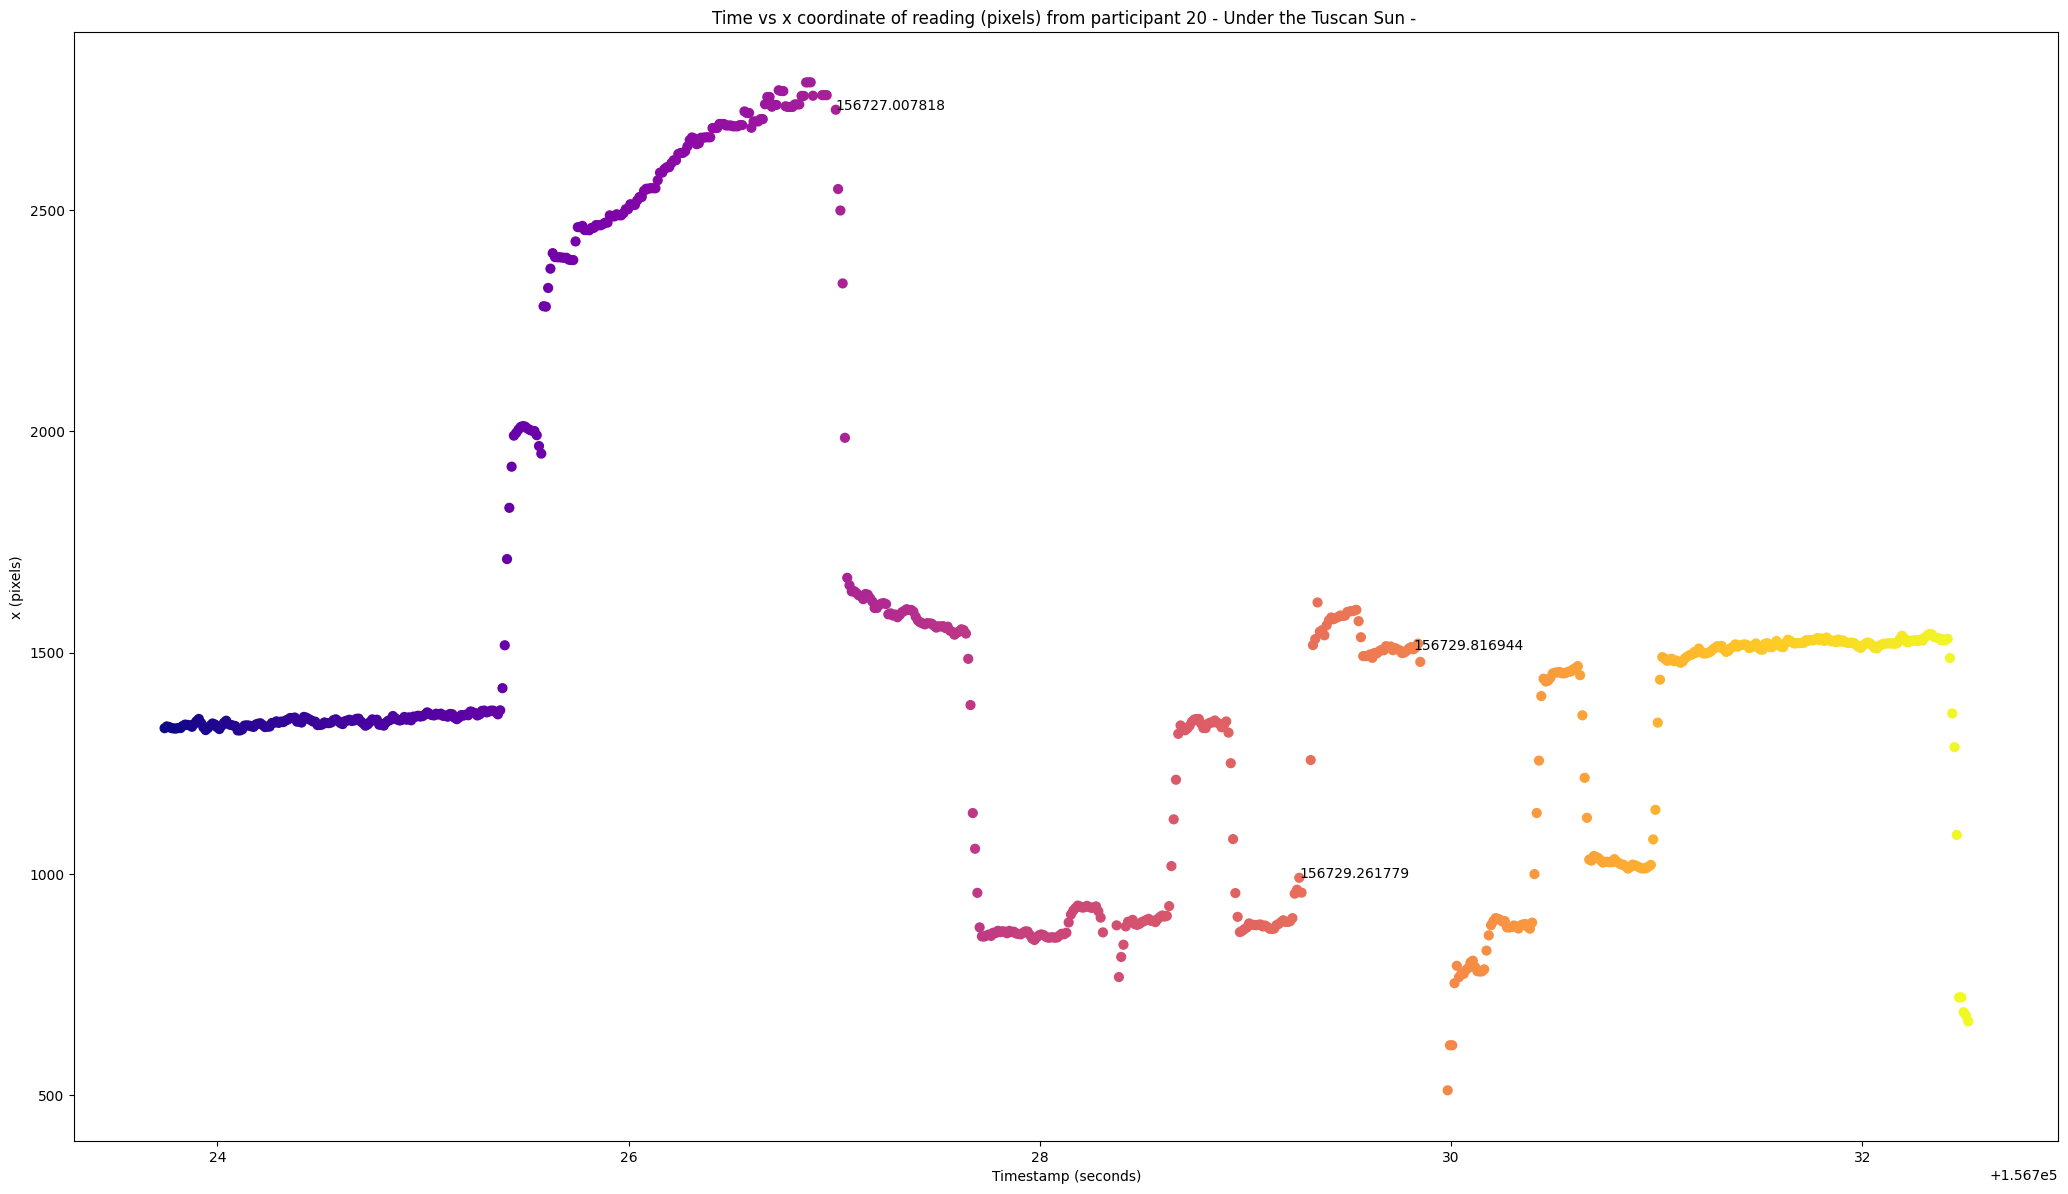

In [12]:
# Look at participant 15 for the book "Chasing sunsets"

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from utils import (
    DEGREES_PER_PIXEL,
    TIMESTAMP_IDENT,
    X_PIXELS,
    Y_PIXELS,
    Events,
    extract_gaze_data_between_timestamps_proper,
    get_participant_dominant_eye,
)
import json

from velocityThreshold import detect_fix_ivt, find_sacc_from_fix

EYE_TRACKER_FOLDER = "eye_tracker_data/"
GAZE_DATA = []
GAZE_DATA_BOOK = []
GAZE_DATA_PAGE = []

# participants that were told that they can change the settings beforehand
participant_ids = [20]
subquery = Events.select().where(Events.participant_id.in_(participant_ids))

for participant in participant_ids:
    books = subquery.where(
        (Events.event == "OPEN_BOOK")
        & (Events.participant_id == participant)
        # & (Events.new_value == "Smart Farming Tech - ")
        & (Events.new_value == "Under the Tuscan Sun - ")
    )
    for book in books:
        START_TIME_BOOK = book.time
        book_end = (
            subquery.where(Events.event == "CLOSE_BOOK")
            .where(Events.time > START_TIME_BOOK)
            .get()
        )
        END_TIME_BOOK = book_end.time

        # Get the events that have a timestamp less than the first CLOSE_BOOK event
        events_book = subquery.where(Events.time <= END_TIME_BOOK)

        LOW_RES = json.load(open("participants.json", "r"))[f"{book.participant_id}"][
            "low_resolution"
        ]

        formatted_time = datetime.fromtimestamp(START_TIME_BOOK / 1000).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )
        GAZE_FILE = f"{EYE_TRACKER_FOLDER}[{participant}]-{formatted_time}.json"
        f = open(GAZE_FILE, "r")
        GAZE_DATA_BOOK = json.load(f)
        f.close()

        DOMINANT_EYE = get_participant_dominant_eye(participant)

        pages = subquery.where(
            (Events.event.contains("_PAGE") | (Events.event == "OPEN_BOOK"))
            & (Events.time >= START_TIME_BOOK)
            & (Events.time < END_TIME_BOOK)
        )
        for page in pages:
            # if page.id != 1006:
            # continue
            START_TIME_PAGE = page.time
            page_end = subquery.where(
                (Events.event.contains("_PAGE")) & (Events.time > START_TIME_PAGE)
            ).get_or_none()
            if page_end is None:
                continue
            END_TIME_PAGE = page_end.time

            GAZE_DATA_PAGE = extract_gaze_data_between_timestamps_proper(
                GAZE_DATA_BOOK, START_TIME_PAGE, END_TIME_PAGE
            )

            fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))
            # set ax limits
            #             ax.set_xlim(0, X_PIXELS)
            # ax.set_ylim(Y_PIXELS, 0)
            img = plt.imread(page.screenshot_file)

            timestamps = []
            x = []
            y = []

            # for each packet, plot the gaze point
            for packet in GAZE_DATA_PAGE["data"]:
                if packet[f"{DOMINANT_EYE}_gaze_point_validity"] == 0:
                    continue
                x.append(
                    packet[f"{DOMINANT_EYE}_gaze_point_on_display_area"][0] * X_PIXELS
                )
                y.append(
                    packet[f"{DOMINANT_EYE}_gaze_point_on_display_area"][1] * Y_PIXELS
                )
                timestamps.append(packet[TIMESTAMP_IDENT])

            df = pd.DataFrame({"x": x, "y": y, "ts": timestamps})
            df = df.sort_values(by="ts")
            df = df.reset_index(drop=True)

            df["x"] = df["x"]
            df["y"] = df["y"] * DEGREES_PER_PIXEL
            df["ts"] = df["ts"] / 1_000_000

            # display(df)
            SACCADIC_THRESHOLD = 80
            # Plot fixations
            fixations, v, labels = detect_fix_ivt(df, sacvel=SACCADIC_THRESHOLD)
            saccades = find_sacc_from_fix(fixations)

            ax.set_title(f"Time vs x coordinate of reading (pixels) from participant {participant} - {book.new_value}")
            p = ax.scatter(
                df["ts"],
                df["x"],
                c=df["ts"],
                s=40,
                cmap="plasma",
                label=f"Participant {participant} - {book.new_value}",
            )

            interesting_ts = [
                156729816944,
                156687857665,
                156668959899,
                156729261778,
                156580200388,
                156525272547,
                156690178245,
                156729261779,
                156727007818,
                156668848865,
                156491540766,
            ]
            # interesting_ts = [
            #     156773608402,
            #     156843192566,
            #     156923047328,
            #     156923047327,
            #     156847089813,
            #     156933628741,
            #     156831689589,
            #     156760229003,
            #     156926555964,
            #     156910100895,
            #     156755587676,
            #     156808483773,
            #     156943688310,
            #     156754499622,
            # ]

            for i, txt in enumerate(df["ts"]):
                if (txt * 1_000_000) in interesting_ts:
                    ax.annotate(
                        txt,
                        (df["ts"][i], df["x"][i]),
                    )

            ax.set_xlabel("Timestamp (seconds)")
            ax.set_ylabel("x (pixels)")

            # p = ax.scatter(x, y, c=timestamps, s=10, cmap="plasma")
            # # show color bar for timestamps
            # fig.colorbar(p, ax=ax)
            # ax.imshow(img, extent=[0, X_PIXELS, Y_PIXELS, 0])
            # ax.set_title(
            #     f"Participant {participant} - {book.new_value}"
            # )

            # # ax.set_xlabel("Distance (degrees)")
            # # ax.set_ylabel("Duration (seconds)")